In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from tqdm import tqdm

In [24]:
def load_images(batch_dir):
    search_image = cv2.imread(str(batch_dir / "search_area_mask.png"), 0)
    region_dir = batch_dir / "regoins_segments"
    region_images = sorted(region_dir.glob("*.png"))
    return search_image, region_images




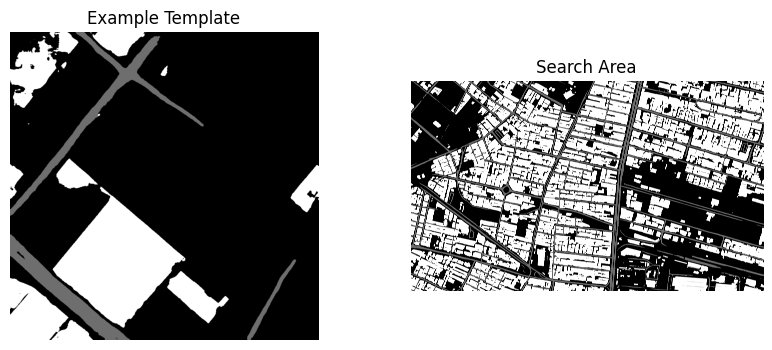

In [28]:
example_dir = Path("matching/tests/1")
search_image = cv2.imread(str(example_dir / "search_area_mask.png"), 0)
region_path = sorted((example_dir / "regoins_segments").glob("*.png"))[0]
template = cv2.imread(str(region_path), 0)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(template, cmap='gray')
plt.title("Example Template")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(search_image, cmap='gray')
plt.title("Search Area")
plt.axis('off')
plt.show()


In [25]:
def multiscale_template_matching(search_img, template, scales=np.linspace(0.5, 1.5, 20)):
    best_val = -np.inf
    best_top_left = None
    best_br = None
    best_scale = 1.0

    for scale in scales:
        scaled_template = cv2.resize(template, None, fx=scale, fy=scale)
        if scaled_template.shape[0] > search_img.shape[0] or scaled_template.shape[1] > search_img.shape[1]:
            continue
        res = cv2.matchTemplate(search_img, scaled_template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        if max_val > best_val:
            best_val = max_val
            best_top_left = max_loc
            best_br = (max_loc[0] + scaled_template.shape[1], max_loc[1] + scaled_template.shape[0])
            best_scale = scale

    return best_top_left, best_br, best_val, best_scale

In [26]:
def evaluate_batches(base_path):
    results = []
    for batch_dir in Path(base_path).glob("*"):
        if not batch_dir.is_dir():
            continue

        search_img, region_paths = load_images(batch_dir)
        for template_path in region_paths:
            template = cv2.imread(str(template_path), 0)
            tl, br, val, scale = multiscale_template_matching(search_img, template)
            results.append({
                "batch": batch_dir.name,
                "template": template_path.name,
                "score": val,
                "scale": scale
            })
    return pd.DataFrame(results)

  batch template     score     scale
0     1    0.png  0.500561  0.500000
1     1    1.png  0.668679  1.026316
2     1   10.png  0.460883  0.973684
3     1   11.png  0.517242  0.973684
4     1   12.png  0.562760  1.026316


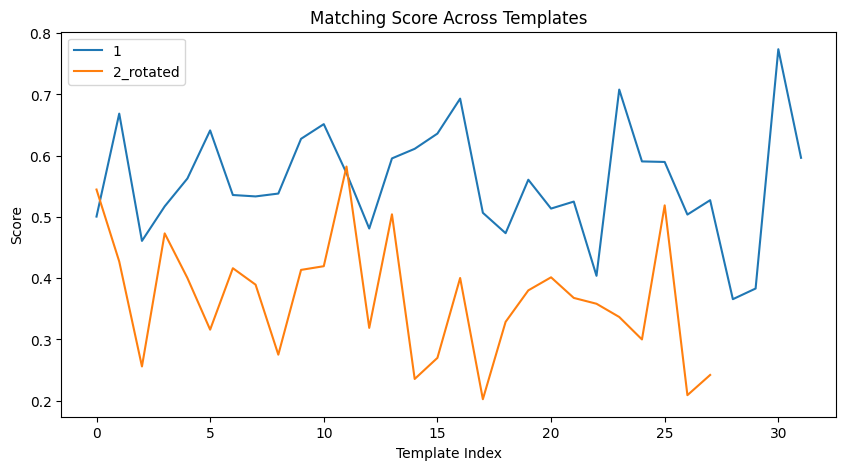

In [27]:
df = evaluate_batches("matching/tests")
print(df.head())

plt.figure(figsize=(10, 5))
for batch in df['batch'].unique():
    subset = df[df['batch'] == batch]
    plt.plot(subset['score'].values, label=batch)
plt.title("Matching Score Across Templates")
plt.xlabel("Template Index")
plt.ylabel("Score")
plt.legend()
plt.show()